# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [16]:
import sys
import random

import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
# You may add any imports you need

from IPython.display import clear_output
from torch.optim.lr_scheduler import ExponentialLR


In [2]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip

--2021-11-04 07:20:59--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/33l8lp62rmvtx40/dataset.zip [following]
--2021-11-04 07:20:59--  https://www.dropbox.com/s/raw/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce56c2c64a358b5899d535c3996.dl.dropboxusercontent.com/cd/0/inline/BZU--vsx3Q2u2hY6gAaCBNjs5GfzRLSqkf6771C_7qSvIriqE_kNp8I0ACbN88iC8HkMDWNugACivf4eZYB5aK45srdgleBFM-EQUMbWz8Pd5KWlKgYcEKCy-xaMuFQI5mdi_gOhuDUBuEk0SCq4KFSa/file# [following]
--2021-11-04 07:20:59--  https://uce56c2c64a358b5899d535c3996.dl.dropboxusercontent.com/cd/0/inline/BZU--vsx3Q2u2hY6gAaCBNjs5GfzRLSqkf6771C_7qSvIriqE_kNp8I0ACbN88iC8HkMDWNugACivf4eZYB5aK45srdgl

In [3]:
!unzip -o "dataset.zip" -d "./" > /dev/null


In [4]:
!ls dataset/dataset/

train  val


### Подготовка данных

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]
)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]
)

train_dataset = ImageFolder("./dataset/dataset/train", transform=train_transform)
val_dataset = ImageFolder("./dataset/dataset/val", transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

In [6]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [7]:
# Код с 6-го семинара
def train_one_epoch(model, data_loader, criterion, optimizer, device="cuda:0"):
    model = model.to(device).train()
    total_loss = 0
    losses = np.array([])
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            # Move Batch to device
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            elementwise_loss = criterion(predicted, labels)
            loss = torch.mean(elementwise_loss)
            
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss = loss.cpu().detach().numpy()
            elementwise_loss = elementwise_loss.cpu().detach().numpy()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).cpu().float().mean().numpy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item(), 4)}"
            )
            prbar.update(1)

            losses = np.append(losses, elementwise_loss)
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
    
    return losses, total_predictions, total_labels


# Код с 5-го семинара
def predict(model, data_loader, criterion, device="cuda:0"):
    model = model.eval()
    losses = np.array([])
    total_predictions = np.array([])
    total_labels = np.array([])
    with torch.no_grad():
        with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
            for images, labels in data_loader:
                # Move Batch to device
                images = images.to(device)
                labels = labels.to(device)
                predicted = model(images)
                elementwise_loss = criterion(predicted, labels)

                # Move data back to cpu
                elementwise_loss = elementwise_loss.cpu()
                predicted_classes = predicted.argmax(1).cpu()

                # Compute metrics
                batch_loss = torch.mean(elementwise_loss).numpy()
                batch_accuracy = torch.mean((predicted_classes == labels.cpu()).float()).numpy()
                prbar.set_description(
                    f"Loss: {round(batch_loss.item(), 4)} "
                    f"Accuracy: {round(batch_accuracy.item(), 4)}"
                )
                prbar.update(1)

                losses = np.append(losses, elementwise_loss.numpy())
                total_predictions = np.append(total_predictions, predicted_classes.numpy())
                total_labels = np.append(total_labels, labels.cpu().numpy())

    return losses, total_predictions, total_labels


# частично с помощью https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html
def plot_metrics(train, val):
    clear_output(True)
    fig, axs = plt.subplots(2, figsize=(13, 14))
    fig.suptitle('Learning progress')

    epoch = len(train['loss'])
    for i, metric_name in enumerate(['loss', 'accuracy']):
        train_metric = train[metric_name]
        val_metric = val[metric_name]
        axs[i].set_title(metric_name)
        axs[i].set(xlabel='epoch', ylabel=metric_name)
        axs[i].plot(np.arange(1, epoch + 1), train_metric, label='train', color='r')
        axs[i].plot(np.arange(1, epoch + 1), val_metric, label='validation', color='b')
        axs[i].scatter(epoch, train_metric[-1], label='Last {}={:.2f} on train'.format(metric_name, train_metric[-1]), color='r')
        axs[i].scatter(epoch, val_metric[-1], label='Last {}={:.2f} on validation'.format(metric_name, val_metric[-1]), color='b')
    plt.legend()
    plt.show()

# Частично мой код из первого домашнего задания
def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    train_metrics = {
        'loss' : [],
        'accuracy' : []
    }
    val_metrics = {
        'loss' : [],
        'accuracy' : []
    }
    for epoch in range(n_epochs):
        losses, predicted_classes, true_classes = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        train_metrics['loss'].append(losses.mean())
        train_metrics['accuracy'].append((predicted_classes == true_classes).astype(float).mean())

        losses, predicted_classes, true_classes = predict(model, val_dataloader, criterion, device)
        val_metrics['loss'].append(losses.mean())
        val_metrics['accuracy'].append((predicted_classes == true_classes).astype(float).mean())
        
        if scheduler is not None:
            scheduler.step()
        
        plot_metrics(train_metrics, val_metrics)

### Обучение модели, запуски экспериментов

In [26]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# Архитектура из https://www.machinecurve.com/index.php/2020/02/09/how-to-build-a-convnet-for-cifar-10-and-cifar-100-classification-with-keras/
# С добавлением батчнорма
def get_model():
    return nn.Sequential(
        nn.Conv2d(3, 64, 3),
        nn.ReLU(),
        # nn.Dropout(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, 3),
        nn.ReLU(),
        # nn.Dropout(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 256, 3),
        nn.ReLU(),
        # nn.Dropout(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(9216, 2048),
        nn.Dropout(),
        nn.ReLU(),
        nn.BatchNorm1d(2048),

        nn.Linear(2048, 512),
        nn.Dropout(),
        nn.ReLU(),
        nn.BatchNorm1d(512),

        nn.Linear(512, 200),
    ).to(device)

Простой тест на проверку правильности написанного кода

In [35]:
model = get_model()
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 5.2989 Accuracy: 0.0: 100%|██████████| 40/40 [00:07<00:00,  5.70it/s]
tests passed


Запустить обучение можно в ячейке ниже.

In [27]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

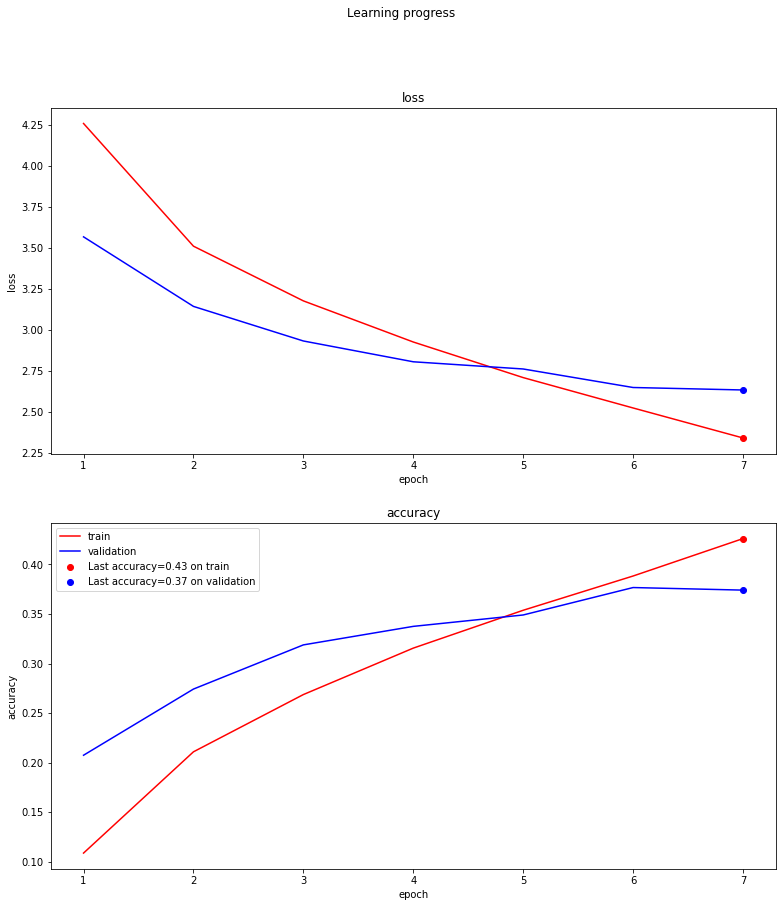

Loss: 2.2073 Accuracy: 0.4805:  29%|██▉       | 113/391 [00:48<01:58,  2.36it/s]

In [ ]:
set_random_seed(42)
model = get_model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer, gamma=0.95)
# scheduler = None
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, 20, scheduler)

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5 * accuracy / 0.44)))

### Отчёт об экспериментах 

текст писать тут